In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [2]:
data = pd.read_csv('input/Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [3]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].shape[0])
print(data[ data['sentiment'] == 'Negative'].shape[0])

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)


2236
8493


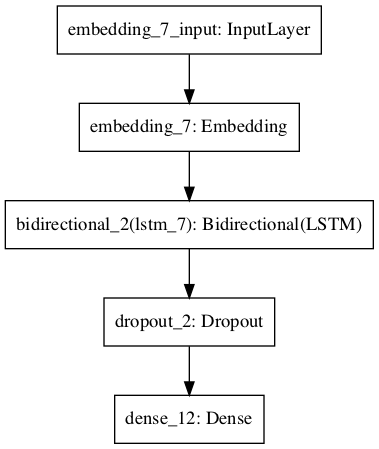

In [17]:
embed_dim = 128
lstm_out = 196

# 第四版
model = Sequential()
model.add(Embedding(max_fatures, 128, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

# 第三版
# model = Sequential()
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(32,activation='relu'))
# model.add(Dense(2,activation='sigmoid'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())


# 第二版
# model = Sequential()
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(2,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

# 第一版
# model = Sequential()
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(2,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())
plot_model(model, to_file='model.png')

In [12]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7188, 28) (7188, 2)
(3541, 28) (3541, 2)


In [18]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)
# model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size)

Epoch 1/7
225/225 - 10s - loss: 0.4228 - accuracy: 0.8197
Epoch 2/7
225/225 - 5s - loss: 0.3018 - accuracy: 0.8760
Epoch 3/7
225/225 - 5s - loss: 0.2515 - accuracy: 0.8979
Epoch 4/7
225/225 - 5s - loss: 0.2108 - accuracy: 0.9142
Epoch 5/7
225/225 - 10s - loss: 0.1747 - accuracy: 0.9293
Epoch 6/7
225/225 - 7s - loss: 0.1497 - accuracy: 0.9406
Epoch 7/7
225/225 - 8s - loss: 0.1337 - accuracy: 0.9449


In [19]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

64/64 - 2s - loss: 0.5550 - accuracy: 0.8285
score: 0.56
acc: 0.83


In [20]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):

    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 1s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

In [49]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  206  633    6  150    5   55 1055   55   46    6  150]]
1/1 - 0s
negative
